<a href="https://colab.research.google.com/github/sada95/IA/blob/master/text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [2]:
print(tf.__version__)

2.4.1


Analyse des sentiments

Ce bloc-notes forme un modèle d'analyse des sentiments pour classer les critiques de films comme positives ou négatives , en fonction du texte de la critique. Il s'agit d'un exemple de classification binaire - ou à deux classes -, un type de problème d'apprentissage automatique important et largement applicable.

Vous utiliserez le jeu de données Large Movie Review qui contient le texte de 50 000 critiques de films de la base de données de films Internet . Celles-ci sont divisées en 25 000 évaluations pour la formation et 25 000 évaluations pour les tests. Les ensembles de formation et de test sont équilibrés , ce qui signifie qu'ils contiennent un nombre égal d'avis positifs et négatifs.


Téléchargez et explorez le jeu de données IMDB

Téléchargeons et extrayons l'ensemble de données, puis explorons la structure des répertoires.

In [3]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84131840/84125825 [==============================] - 2s 0us/step


In [4]:
os.listdir(dataset_dir)

['README', 'imdbEr.txt', 'train', 'test', 'imdb.vocab']

In [5]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'urls_neg.txt',
 'neg',
 'urls_unsup.txt',
 'urls_pos.txt',
 'pos',
 'unsupBow.feat',
 'unsup']

Les **aclImdb/train/pos** et **aclImdb/train/neg** contiennent de nombreux fichiers texte, dont chacun est une seule critique de film. Jetons un coup d'œil à l'un d'entre eux.

In [6]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


**Charger le jeu de données**

Ensuite, vous allez charger les données du disque et les préparer dans un format adapté à la formation. Pour ce faire, vous utiliserez l'utilitaire utile text_dataset_from_directory , qui attend une structure de répertoires comme suit.

In [ ]:
main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt

Pour préparer un ensemble de données pour la classification binaire, vous aurez besoin de deux dossiers sur le disque, correspondant à class_a et class_b . Ce seront les critiques de films positives et négatives, qui peuvent être trouvées dans aclImdb/train/pos et aclImdb/train/neg . Comme l'ensemble de données IMDB contient des dossiers supplémentaires, vous les supprimerez avant d'utiliser cet utilitaire.

In [8]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

Ensuite, vous utiliserez l'utilitaire text_dataset_from_directory pour créer untf.data.Dataset étiqueté. tf.data est une puissante collection d'outils pour travailler avec des données.

Lors de l'exécution d'une expérience d'apprentissage automatique, il est recommandé de diviser votre ensemble de données en trois divisions: entraînement , validation et test .

L'ensemble de données IMDB a déjà été divisé en train et test, mais il manque un ensemble de validation. Créons un ensemble de validation en utilisant une division 80:20 des données d'entraînement en utilisant l'argument validation_split ci-dessous.

In [9]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


Comme vous pouvez le voir ci-dessus, il y a 25 000 exemples dans le dossier de formation, dont vous utiliserez 80% (ou 20 000) pour la formation. Comme vous le verrez dans un instant, vous pouvez entraîner un modèle en passant un jeu de données directement à **model.fit** . Si vous **tf.data** avec **tf.data** , vous pouvez également parcourir l'ensemble de données et imprimer quelques exemples comme suit.

In [10]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

Notez que les critiques contiennent du texte brut (avec ponctuation et balises HTML occasionnelles comme <br/> ). Vous montrerez comment les gérer dans la section suivante.

Les libellés sont 0 ou 1. Pour voir lesquels correspondent aux critiques de films positives et négatives, vous pouvez vérifier la propriété class_names sur l'ensemble de données.

In [11]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


Ensuite, vous allez créer un ensemble de données de validation et de test. Vous utiliserez les 5 000 avis restants de l'ensemble de formation pour la validation

In [12]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


Remarque: lorsque vous utilisez les arguments validation_split et subset , assurez-vous de spécifier une valeur de départ aléatoire ou de transmettre shuffle=False , afin que les fractionnements de validation et d'apprentissage ne se chevauchent pas.

In [13]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [14]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


**Remarque: les API de prétraitement utilisées dans la section suivante sont expérimentales dans TensorFlow 2.3 et sujettes à modification.**

Préparez l'ensemble de données pour la formation
Ensuite, vous allez standardiser, tokeniser et vectoriser les données à l'aide de la couche de **preprocessing.TextVectorization** traitement.TextVectorization utile.

La normalisation fait référence au prétraitement du texte, généralement pour supprimer la ponctuation ou les éléments HTML pour simplifier l'ensemble de données. La tokenisation fait référence à la division de chaînes en jetons (par exemple, la division d'une phrase en mots individuels, par division sur un espace). La vectorisation fait référence à la conversion de jetons en nombres afin qu'ils puissent être introduits dans un réseau neuronal. Toutes ces tâches peuvent être accomplies avec cette couche.

Comme vous l'avez vu ci-dessus, les critiques contiennent diverses balises HTML telles que <br /> . Ces balises ne seront pas supprimées par le standardiseur par défaut dans la couche **TextVectorization** (qui convertit le texte en minuscules et supprime la ponctuation par défaut, mais ne supprime pas le HTML). Vous allez écrire une fonction de standardisation personnalisée pour supprimer le HTML.

**Remarque: pour éviter le biais train / test (également appelé biais train / service), il est important de prétraiter les données de manière identique au moment du train et du test. Pour faciliter cela, la couche TextVectorization peut être incluse directement dans votre modèle, comme indiqué plus loin dans ce didacticiel.**

In [15]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

Ensuite, vous allez créer un calque TextVectorization . vous utiliserez cette couche pour standardiser, tokeniser et vectoriser nos données. Vous définissez output_mode sur int pour créer des indices d'entiers uniques pour chaque jeton.

Notez que vous utilisez la fonction de fractionnement par défaut et la fonction de standardisation personnalisée que vous avez définie ci-dessus. Vous aurez également définir des constantes pour le modèle, comme un maximum de explicite sequence_length , ce qui entraînera la couche à des séquences de pad ou tronquer exactement sequence_length valeurs.

In [16]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

Ensuite, vous appellerez adapt pour adapter l'état de la couche de prétraitement à l'ensemble de données. Cela obligera le modèle à créer un index de chaînes vers des entiers.

**Remarque: il est important de n'utiliser vos données d'entraînement que lors de l'appel d'adapt (l'utilisation de l'ensemble de test entraînerait une fuite d'informations).**

In [17]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Créons une fonction pour voir le résultat de l'utilisation de cette couche pour prétraiter certaines données.

In [18]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [19]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />T

Comme vous pouvez le voir ci-dessus, chaque jeton a été remplacé par un entier. Vous pouvez rechercher le jeton (chaîne) auquel correspond chaque entier en appelant .get_vocabulary() sur la couche.

In [20]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


Vous êtes presque prêt à entraîner votre modèle. Lors de la dernière étape de prétraitement, vous appliquerez la couche TextVectorization que vous avez créée précédemment à l'ensemble de données de train, de validation et de test

In [22]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

Configurer l'ensemble de données pour les performances
Ce sont deux méthodes importantes que vous devez utiliser lors du chargement de données pour vous assurer que les E / S ne deviennent pas bloquantes.

.cache() garde les données en mémoire après leur chargement hors du disque. Cela garantira que l'ensemble de données ne deviendra pas un goulot d'étranglement lors de l'entraînement de votre modèle. Si votre ensemble de données est trop volumineux pour tenir dans la mémoire, vous pouvez également utiliser cette méthode pour créer un cache sur disque performant, qui est plus efficace à lire que de nombreux petits fichiers.

.prefetch() chevauche le prétraitement des données et l'exécution du modèle pendant l'entraînement.

Vous pouvez en savoir plus sur les deux méthodes, ainsi que sur la mise en cache des données sur le disque dans le guide des performances des données .

In [23]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Créer le modèle

Il est temps de créer notre réseau de neurones:

In [24]:
embedding_dim = 16

In [25]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


Les couches sont empilées séquentiellement pour construire le classificateur:

La première couche est une couche d' Embedding . Cette couche prend les révisions encodées en nombre entier et recherche un vecteur d'incorporation pour chaque index de mot. Ces vecteurs sont appris au fur et à mesure des trains modèles. Les vecteurs ajoutent une dimension au tableau de sortie. Les dimensions résultantes sont: (batch, sequence, embedding) . Pour en savoir plus sur les incorporations, consultez le didacticiel sur l'intégration de mots .
Ensuite, une couche GlobalAveragePooling1D renvoie un vecteur de sortie de longueur fixe pour chaque exemple en calculant la moyenne sur la dimension de séquence. Cela permet au modèle de gérer des entrées de longueur variable, de la manière la plus simple possible.
Ce vecteur de sortie de longueur fixe est acheminé via une couche entièrement connectée ( Dense ) avec 16 unités cachées.
La dernière couche est étroitement connectée avec un seul nœud de sortie.

Fonction de perte et optimiseur
Un modèle a besoin d'une fonction de perte et d'un optimiseur pour l'entraînement. Puisqu'il s'agit d'un problème de classification binaire et que le modèle génère une probabilité (une couche à une seule unité avec une activation sigmoïde), vous utiliserez losses.BinaryCrossentropy perte de losses.BinaryCrossentropy .

Maintenant, configurez le modèle pour utiliser un optimiseur et une fonction de perte:

In [26]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

**Former le modèle**

Vous allez entraîner le modèle en passant l'objet du dataset à la méthode fit.

In [27]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 13s 19ms/step - loss: 0.6820 - binary_accuracy: 0.6175 - val_loss: 0.6145 - val_binary_accuracy: 0.7728
Epoch 2/10
625/625 [==============================] - 4s 7ms/step - loss: 0.5797 - binary_accuracy: 0.7844 - val_loss: 0.4986 - val_binary_accuracy: 0.8230
Epoch 3/10
625/625 [==============================] - 4s 7ms/step - loss: 0.4662 - binary_accuracy: 0.8356 - val_loss: 0.4201 - val_binary_accuracy: 0.8484
Epoch 4/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3916 - binary_accuracy: 0.8611 - val_loss: 0.3737 - val_binary_accuracy: 0.8614
Epoch 5/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3448 - binary_accuracy: 0.8770 - val_loss: 0.3449 - val_binary_accuracy: 0.8682
Epoch 6/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3113 - binary_accuracy: 0.8841 - val_loss: 0.3257 - val_binary_accuracy: 0.8724
Epoch 7/10
625/625 [==============================] - 4s 7ms/s

**Évaluer le modèle**

Voyons comment le modèle fonctionne. Deux valeurs seront renvoyées. Perte (un nombre qui représente notre erreur, les valeurs inférieures sont meilleures) et précision.

In [28]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 11s 14ms/step - loss: 0.3103 - binary_accuracy: 0.8735
Loss:  0.31025710701942444
Accuracy:  0.8734800219535828


Cette approche assez naïve atteint une précision d'environ 86%.

Créez un graphique de la précision et de la perte au fil du temps

model.fit() retourne un objet History qui contient un dictionnaire avec tout ce qui s'est passé pendant l'entraînement:

In [29]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

Il y a quatre entrées: une pour chaque métrique surveillée pendant la formation et la validation. Vous pouvez les utiliser pour tracer la perte de formation et de validation à des fins de comparaison, ainsi que la précision de la formation et de la validation:

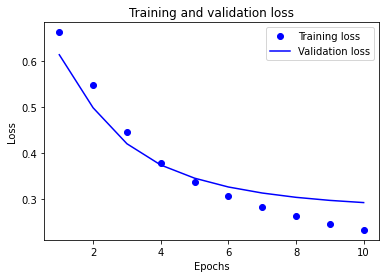

In [30]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

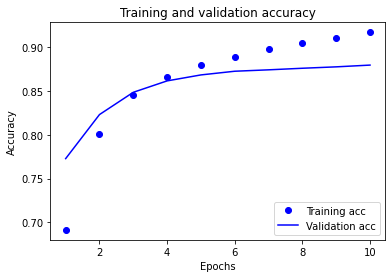

In [31]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

Dans ce graphique, les points représentent la perte et la précision de la formation, et les lignes pleines représentent la perte de validation et la précision.

Notez que la perte de formation diminue à chaque époque et que la précision de la formation augmente à chaque époque. Ceci est attendu lors de l'utilisation d'une optimisation de descente de gradient - cela doit minimiser la quantité souhaitée à chaque itération.

Ce n'est pas le cas pour la perte de validation et la précision: elles semblent culminer avant la précision de la formation. Voici un exemple de surajustement: le modèle fonctionne mieux sur les données d'entraînement que sur des données qu'il n'a jamais vues auparavant. Après ce point, le modèle sur-optimise et apprend des représentations spécifiques aux données d'entraînement qui ne se généralisent pas aux données de test.

Dans ce cas particulier, vous pouvez éviter le surajustement en arrêtant simplement l'entraînement lorsque la précision de validation n'augmente plus. Une façon de le faire est d'utiliser le rappel tf.keras.callbacks.EarlyStopping .

**Exporter le modèle**

Dans le code ci-dessus, vous avez appliqué la couche TextVectorization au jeu de données avant d'alimenter le modèle en texte. Si vous souhaitez rendre votre modèle capable de traiter des chaînes brutes (par exemple, pour simplifier son déploiement), vous pouvez inclure la couche TextVectorization dans votre modèle. Pour ce faire, vous pouvez créer un nouveau modèle en utilisant les poids que vous venez de former.

In [32]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 11s 13ms/step - loss: 0.3105 - accuracy: 0.8734
0.8734800219535828


Inférence sur de nouvelles données
Pour obtenir des prédictions pour de nouveaux exemples, vous pouvez simplement appeler model.predict()

In [33]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

array([[0.637556  ],
       [0.46248072],
       [0.38079363]], dtype=float32)

L'inclusion de la logique de prétraitement du texte à l'intérieur de votre modèle vous permet d'exporter un modèle pour la production qui simplifie le déploiement et réduit le potentiel d' inclinaison du train / test .

Il y a une différence de performances à garder à l'esprit lorsque vous choisissez où appliquer votre couche TextVectorization. Son utilisation en dehors de votre modèle vous permet d'effectuer un traitement CPU asynchrone et une mise en mémoire tampon de vos données lors de l'entraînement sur GPU. Donc, si vous entraînez votre modèle sur le GPU, vous voudrez probablement utiliser cette option pour obtenir les meilleures performances lors du développement de votre modèle, puis passer à l'inclusion de la couche TextVectorization dans votre modèle lorsque vous êtes prêt à préparer le déploiement. .

Consultez ce didacticiel pour en savoir plus sur l'enregistrement des modèles.